In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid, save_image
%matplotlib inline

In [2]:
dataset = torch.load('Embedding_CelebA64.pth')

In [3]:
class SelebA_embedding(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.data = dataset[:65000] if train else dataset[65000:]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx, :-2], 2 * self.data[idx, -2].long() + 1 * self.data[idx, -1].long() - 1

In [4]:
train_dataset = SelebA_embedding(train=True)
val_dataset = SelebA_embedding(train=False)
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [57]:
class Generator(nn.Module):
    def __init__(self, num_classes, input_dim):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(num_classes, input_dim // 2)
        self.block1 = nn.Sequential(
            nn.Dropout(0.8),
            nn.Linear(input_dim + input_dim // 2, input_dim + input_dim // 2),
            #nn.BatchNorm1d(input_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.block2 = nn.Sequential(
            nn.Linear(input_dim + input_dim // 2, input_dim),
            #nn.BatchNorm1d(input_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.block3 = nn.Linear(input_dim, input_dim)
    def forward(self, input, label):
        out = torch.cat((input, self.embedding(label)), dim=1)
        return self.block3(self.block2(self.block1(out)))

In [58]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(input_dim, input_dim),
            #nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.block2 = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            #nn.BatchNorm1d(input_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            #nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(input_dim // 2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            #nn.BatchNorm1d(input_dim // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(input_dim // 2, num_classes)
        )
    def forward(self, input):
        out = self.block2(self.block1(input))
        return self.critic(out), self.classifier(out)

In [59]:
disc = Discriminator(128, 3).cuda()
gen = Generator(3, 128).cuda()

optimizer_d = torch.optim.Adam([{'params': disc.block1.parameters(), 'lr': 2e-4, 'betas':(0., 0.99)},
                                #{'params': disc.block2.parameters(), 'lr': 2e-4, 'betas':(0., 0.99)},
                                {'params': disc.critic.parameters(), 'lr': 2e-4, 'betas':(0., 0.99)},
                                {'params': disc.classifier.parameters(), 'lr': 2e-5, 'betas':(0., 0.99)}
                               ])
optimizer_g = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0., 0.99))

fake_criterion = nn.BCEWithLogitsLoss().cuda()
class_criterion = nn.CrossEntropyLoss().cuda()
cycle_criterion = nn.L1Loss().cuda()

d_loss_history = []
g_loss_history = []

In [60]:
for iteration in tqdm_notebook(range(10000)):
    
    # train Discriminator
    x_orig, label = next(iter(train_loader))
    proba_orig, label_pred = disc(x_orig.cuda())
    loss_proba_orig = fake_criterion(proba_orig, torch.ones_like(proba_orig).cuda())
    loss_class_orig = class_criterion(label_pred, label.cuda())
    disc_loss_orig = loss_proba_orig + 0.5 * loss_class_orig
    
    x, _ = next(iter(train_loader))
    label = torch.randint(3, (BATCH_SIZE,)).squeeze()
    x_gen = gen(x.cuda(), label.cuda())
    proba_fake, label_pred = disc(x_gen)
    loss_proba_fake = fake_criterion(proba_fake, torch.zeros_like(proba_fake).cuda())
    loss_class_fake = class_criterion(label_pred, label.cuda())
    disc_loss_fake = loss_proba_fake + 0.5 * loss_class_fake
    
    disc_loss = 0.5 * (disc_loss_orig + disc_loss_fake)
    optimizer_d.zero_grad()
    disc_loss.backward()
    optimizer_d.step()
                
    # train Generator
    x, label_orig = next(iter(train_loader))
    label = torch.randint(3, (BATCH_SIZE,)).squeeze()
    x_gen = gen(x.cuda(), label.cuda())
    x_gen_orig = gen(x_gen, label_orig.cuda())
    loss_cycle = cycle_criterion(x.cuda(), x_gen_orig)
    proba_fake, label_pred = disc(x_gen)
    loss_proba_fake = fake_criterion(proba_fake, torch.ones_like(proba_fake).cuda())
    loss_class_fake = class_criterion(label_pred, label.cuda())
    
    gen_loss = 0.5 * loss_proba_fake + loss_class_fake + 10 * loss_cycle
    optimizer_g.zero_grad()
    gen_loss.backward()
    optimizer_g.step()
    
    d_loss_history.append(disc_loss.item())
    g_loss_history.append(gen_loss.item())

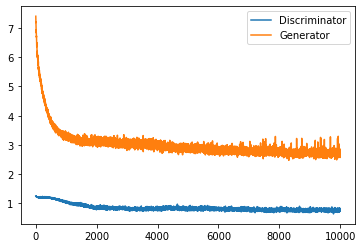

In [61]:
plt.plot(d_loss_history, label='Discriminator')
plt.plot(g_loss_history, label='Generator')
plt.legend();

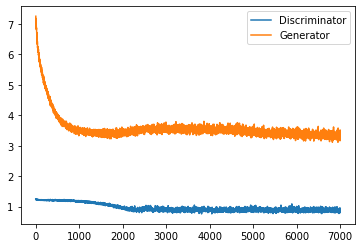

In [50]:
plt.plot(d_loss_history, label='Discriminator')
plt.plot(g_loss_history, label='Generator')
plt.legend();

In [12]:
from modules import Autoencoder

args =  {'dataset': 'MNIST',
         'eval_each': 10,
         'epochs': 101,
         'log_dir': 'CelebA64_256_v2/',
         'device': 'cuda:0',
         'weight_decay': 1e-05,
         'depth': 16,
         'gamma': 0.2,
         'lmbda': 0.5,
         'batch_norm': False,
         'batch_size': 64,
         'colors': 3,
         'latent_width': 4, # Bottleneck HW
         'width': 128, # Means 4 downsampling blocks
         'latent': 32, # Bottleneck channels
         'n_classes': 10,
         'advdepth': 16,
         'lr': 0.0001}
scales = int(round(np.log2(args['width'] // args['latent_width'])))
autoencoder = Autoencoder(scales=scales,depth=args['depth'],latent=args['latent'],colors=args['colors']).to(args['device'])

autoencoder.load_state_dict(torch.load('ae.pt', map_location='cuda'))

<All keys matched successfully>

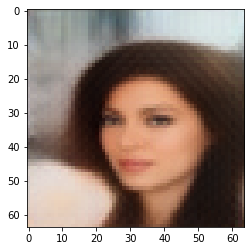

In [34]:
gen.eval()
x, y = train_dataset[425]
x_rec = autoencoder.decoder(x.view(1, 32, 2, 2).cuda())
plt.imshow(x_rec.cpu().detach().squeeze().permute(1, 2, 0));

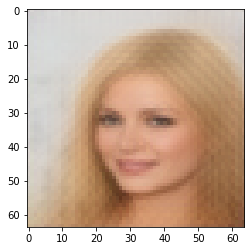

In [35]:
label = torch.tensor(0)
x_gen = gen(x.unsqueeze(0).cuda(), label.unsqueeze(0).cuda())
x_rec = autoencoder.decoder(x_gen.view(1, 32, 2, 2).cuda())
plt.imshow(x_rec.cpu().detach().squeeze().permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


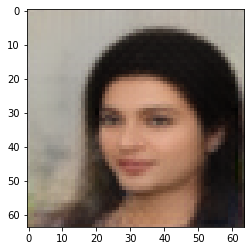

In [36]:
label = torch.tensor(1)
x_gen = gen(x.unsqueeze(0).cuda(), label.unsqueeze(0).cuda())
x_rec = autoencoder.decoder(x_gen.view(1, 32, 2, 2).cuda())
plt.imshow(x_rec.cpu().detach().squeeze().permute(1, 2, 0));

In [15]:
disc(x_gen)

(tensor([[1.3673]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.4047,  2.7137, -5.4656]], device='cuda:0', grad_fn=<AddmmBackward>))

In [65]:
x, label = next(iter(train_loader))
x = x[:8]
x_gen0 = gen(x.cuda(), torch.zeros(8).long().cuda())
x_gen1 = gen(x.cuda(), torch.ones(8).long().cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


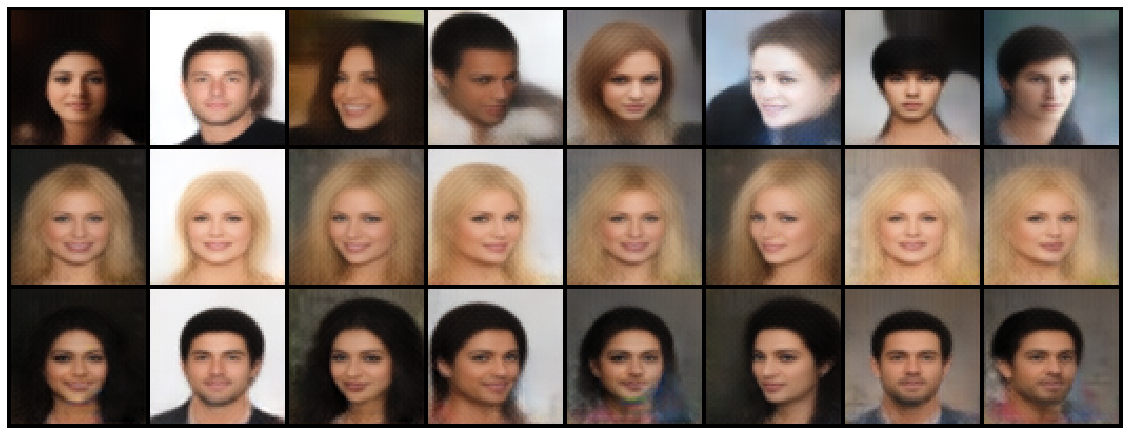

In [39]:
rec_orig = autoencoder.decoder(x.view(8, 32, 2, 2).cuda()).cpu().detach()
rec_gen0 = autoencoder.decoder(x_gen0.view(8, 32, 2, 2).cuda()).cpu().detach()
rec_gen1 = autoencoder.decoder(x_gen1.view(8, 32, 2, 2).cuda()).cpu().detach()

plt.figure(figsize=(20, 10))
plt.imshow(make_grid(torch.cat([rec_orig, rec_gen0, rec_gen1], dim=0)).numpy().transpose((1,2,0)))
plt.axis('off')
plt.savefig('ac-gan.png');